# Kaggle Competition: Quora question pairs

In [33]:
% matplotlib inline 

import re

import pandas as pd
import numpy as np 

from itertools import cycle
import string
import os
from collections import Counter
from tqdm import *

import cPickle as pickle

import bcolz

import seaborn as sns
import matplotlib.pyplot as plt

from keras.layers.embeddings import Embedding
from keras.layers import Input, merge, TimeDistributed, concatenate
from keras.models import Model
from keras.layers.core import Flatten, Dropout, Dense
from keras.optimizers import Adam, Nadam
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution1D, Conv1D

from keras.regularizers import l1, l2

from keras.layers.recurrent import GRU, LSTM

from keras import backend as K

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

from keras.utils.np_utils import to_categorical
import gc

import tensorflow as tf

Check that tensorflow uses my GPU (i.e. that I installed it correctly) 

In [5]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

## Importing the data

In [7]:
train = pd.read_csv('data/Quora/train.csv')

In [8]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [9]:
train = train[train.question2.notnull()]
train = train[train.question1.notnull()]

In [10]:
MAX_LENGTH = 35

In [11]:
embeddings_index = {}
f = open('data/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [12]:
EMBEDDING_DIM = 300

In [13]:
labels = np.asarray(train.is_duplicate)
labels

array([0, 0, 0, ..., 0, 0, 0])

## Cleaning up the text

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation

In [15]:
stop_words = ['the','a','an','and','but','if','or','because','as','what','which','this','that','these','those','then',
              'just','so','than','such','both','through','about','for','is','of','while','during','to','What','Which',
              'Is','If','While','This']

In [16]:
def text_to_wordlist(text, remove_stop_words=True, stem_words=False):
    # Clean the text, with the option to remove stop_words and to stem words.

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"what's", "", text)
    text = re.sub(r"What's", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"60k", " 60000 ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"quikly", "quickly", text)
    text = re.sub(r" usa ", " America ", text)
    text = re.sub(r" USA ", " America ", text)
    text = re.sub(r" u s ", " America ", text)
    text = re.sub(r" uk ", " England ", text)
    text = re.sub(r" UK ", " England ", text)
    text = re.sub(r"india", "India", text)
    text = re.sub(r"switzerland", "Switzerland", text)
    text = re.sub(r"china", "China", text)
    text = re.sub(r"chinese", "Chinese", text) 
    text = re.sub(r"imrovement", "improvement", text)
    text = re.sub(r"intially", "initially", text)
    text = re.sub(r"quora", "Quora", text)
    text = re.sub(r" dms ", "direct messages ", text)  
    text = re.sub(r"demonitization", "demonetization", text) 
    text = re.sub(r"actived", "active", text)
    text = re.sub(r"kms", " kilometers ", text)
    text = re.sub(r"KMs", " kilometers ", text)
    text = re.sub(r" cs ", " computer science ", text) 
    text = re.sub(r" upvotes ", " up votes ", text)
    text = re.sub(r" iPhone ", " phone ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r"calender", "calendar", text)
    text = re.sub(r"ios", "operating system", text)
    text = re.sub(r"gps", "GPS", text)
    text = re.sub(r"gst", "GST", text)
    text = re.sub(r"programing", "programming", text)
    text = re.sub(r"bestfriend", "best friend", text)
    text = re.sub(r"dna", "DNA", text)
    text = re.sub(r"III", "3", text) 
    text = re.sub(r"the US", "America", text)
    text = re.sub(r"Astrology", "astrology", text)
    text = re.sub(r"Method", "method", text)
    text = re.sub(r"Find", "find", text) 
    text = re.sub(r"banglore", "Banglore", text)
    text = re.sub(r" J K ", " JK ", text)
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [17]:
def process_questions(question_list, questions, question_list_name, dataframe):
    '''transform questions and display progress'''
    for question in tqdm(questions):
        question_list.append(text_to_wordlist(question))

In [18]:
train_question1 = []
process_questions(train_question1, train.question1, 'train_question1', train)

100%|██████████| 404288/404288 [00:41<00:00, 9789.93it/s]


In [19]:
train_question2 = []
process_questions(train_question2, train.question2, 'train_question2', train)

100%|██████████| 404288/404288 [00:40<00:00, 9863.46it/s]


## Preparing the data for the neural network 

In [20]:
cleaned_tokenizer = Tokenizer(nb_words = 20000)
cleaned_tokenizer.fit_on_texts(train_question1 + train_question2)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [21]:
clean_q1sequence = cleaned_tokenizer.texts_to_sequences(train_question1)
clean_q2sequence = cleaned_tokenizer.texts_to_sequences(train_question2)

In [22]:
clean_word_index = cleaned_tokenizer.word_index

In [23]:
clean_q1_input = pad_sequences(clean_q1sequence, maxlen = MAX_LENGTH)
clean_q2_input = pad_sequences(clean_q2sequence, maxlen = MAX_LENGTH)

In [24]:
msk = np.random.rand(len(train)) < 0.8

clean_q1_train = clean_q1_input[msk]
clean_q1_valid = clean_q1_input[~msk]

clean_q2_train = clean_q2_input[msk]
clean_q2_valid = clean_q2_input[~msk]

clean_labels_train = labels[msk]
clean_labels_valid = labels[~msk]

In [25]:
q1_train = np.vstack((clean_q1_train, clean_q2_train))
q2_train = np.vstack((clean_q2_train, clean_q1_train))

q1_valid = np.vstack((clean_q1_valid, clean_q2_valid))
q2_valid = np.vstack((clean_q2_valid, clean_q1_valid))

labels_train = np.concatenate((clean_labels_train, clean_labels_train))
labels_valid = np.concatenate((clean_labels_valid, clean_labels_valid))

## Training the neural network

In [26]:
clean_embedding_matrix = np.zeros((len(clean_word_index) + 1, EMBEDDING_DIM))
for word, i in clean_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        clean_embedding_matrix[i] = embedding_vector

In [27]:
clean_embedding_layer = Embedding(len(clean_word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[clean_embedding_matrix],
                            input_length=MAX_LENGTH,
                            trainable=False)

In [39]:
q1_input = Input(shape=(MAX_LENGTH,), dtype = 'int32')
q1_embedded = clean_embedding_layer(q1_input)
q1 = BatchNormalization()(q1_embedded)

q1 = LSTM(225, dropout_U = 0.2, dropout_W = 0.2, consume_less='gpu' )(q1)

#########################

q2_input = Input(shape=(MAX_LENGTH,), dtype = 'int32')
q2_embedded = clean_embedding_layer(q2_input)
q2 = BatchNormalization()(q2_embedded)

q2 = LSTM(225, dropout_U = 0.25, dropout_W = 0.25,  consume_less='gpu')(q2)

#########################

x = concatenate([q1, q2])
x = BatchNormalization()(x)

x = Dense(125, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

clean_preds = Dense(1, activation = 'sigmoid')(x)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(225, recurrent_dropout=0.2, implementation=2, dropout=0.2)`
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(225, recurrent_dropout=0.25, implementation=2, dropout=0.25)`


In [40]:
nlp_nn = Model([q1_input, q2_input], clean_preds)

In [41]:
nlp_nn.compile(loss='binary_crossentropy', optimizer='nadam',
        metrics=['acc'])

In [42]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = 'QUORA_nlp.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

In [43]:
nlp_hist = nlp_nn.fit([q1_train, q2_train], labels_train, batch_size = 2048, 
                                   nb_epoch = 200, shuffle = True,
                     validation_data=([q1_valid, q2_valid],labels_valid),
                     callbacks=[early_stopping, model_checkpoint])

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 647508 samples, validate on 161068 samples
Epoch 1/200
647508/647508 [==============================] - 188s - loss: 0.5188 - acc: 0.7408 - val_loss: 0.5209 - val_acc: 0.7364
Epoch 2/200
647508/647508 [==============================] - 187s - loss: 0.4429 - acc: 0.7881 - val_loss: 0.4286 - val_acc: 0.7939
Epoch 3/200
647508/647508 [==============================] - 187s - loss: 0.4126 - acc: 0.8051 - val_loss: 0.4149 - val_acc: 0.8034
Epoch 4/200
647508/647508 [==============================] - 187s - loss: 0.3925 - acc: 0.8162 - val_loss: 0.4095 - val_acc: 0.8072
Epoch 5/200
647508/647508 [==============================] - 187s - loss: 0.3774 - acc: 0.8245 - val_loss: 0.4073 - val_acc: 0.8100
Epoch 6/200
647508/647508 [==============================] - 187s - loss: 0.3661 - acc: 0.8304 - val_loss: 0.4035 - val_acc: 0.8134
Epoch 7/200
647508/647508 [==============================] - 188s - loss: 0.3557 - acc: 0.8366 - val_loss: 0.4008 - val_acc: 0.8166
Epoch 8/200
647508/64750

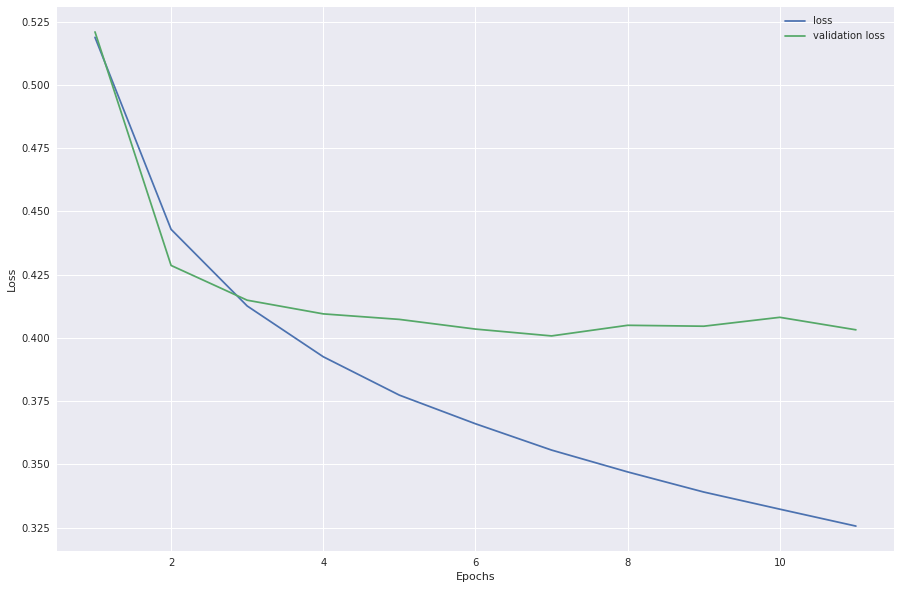

In [52]:
plt.figure(figsize=(15,10))
plt.plot(range(1, 12), nlp_hist.history['loss'], label = 'loss')
plt.plot(range(1, 12), nlp_hist.history['val_loss'], label = 'validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
nlp_hist2 = nlp_nn.fit([q1_train, q2_train], labels_train, batch_size = 2048, 
                                   nb_epoch = 200, shuffle = True,
                     validation_data=([q1_valid, q2_valid],labels_valid),
                     callbacks=[early_stopping, model_checkpoint])

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 647508 samples, validate on 161068 samples
Epoch 1/200
108544/647508 [====>.........................] - ETA: 141s - loss: 0.3098 - acc: 0.8606